# Take-Home Challenge: Ultimate Technologies Inc.

# Part 1

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Data Overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
df.dtypes

login_time    datetime64[ns]
dtype: object

## Data Wrangling

In [6]:
df.set_index('login_time', inplace=True)
df['count'] = 1

In [7]:
df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [8]:
#Count by 15 minute interval

df2 = df.resample('15T').sum()
df2.head(10)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


## Exploratory Data Analysis

### Login count per 15 minute inteval:

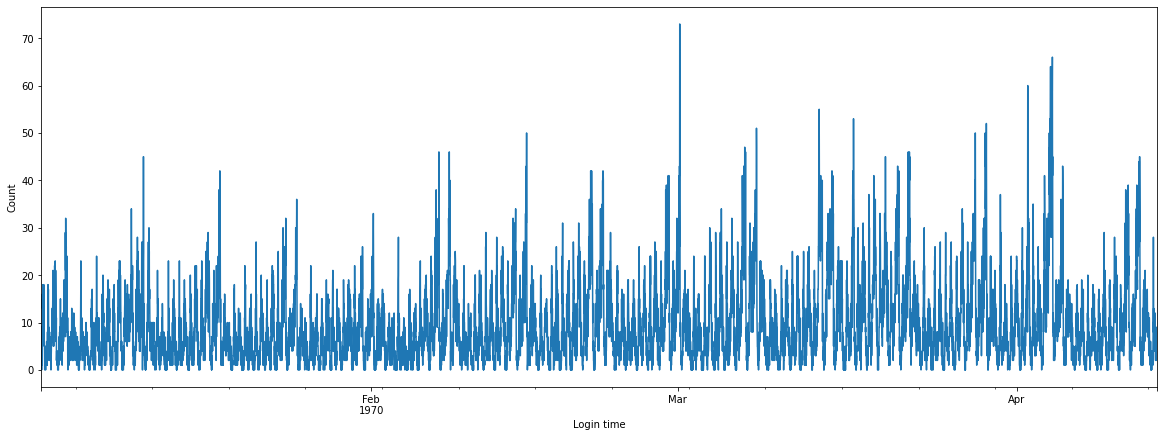

In [9]:
plt.figure(figsize=(20,7))
df2['count'].plot()
plt.xlabel('Login time')
plt.ylabel('Count')
plt.show()

- **We can see a typical weekly cycle that shows high demands on the weekends.**

**Let's see the count by month, day and hour.**

In [10]:
month = list(calendar.month_abbr)
day = list(calendar.day_abbr)

df2['timestamp'] = pd.to_datetime(df2.index)
df2['month'] = df2.timestamp.apply(lambda x: month[x.month])
df2['day'] = df2.timestamp.apply(lambda x: day[x.weekday()])
df2['hour'] = df2.timestamp.apply(lambda x: x.hour)

df2.head(10)

,count,timestamp,month,day,hour
login_time,,,,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00,Jan,Thu,20
1970-01-01 20:15:00,6,1970-01-01 20:15:00,Jan,Thu,20
1970-01-01 20:30:00,9,1970-01-01 20:30:00,Jan,Thu,20
1970-01-01 20:45:00,7,1970-01-01 20:45:00,Jan,Thu,20
1970-01-01 21:00:00,1,1970-01-01 21:00:00,Jan,Thu,21
1970-01-01 21:15:00,4,1970-01-01 21:15:00,Jan,Thu,21
1970-01-01 21:30:00,0,1970-01-01 21:30:00,Jan,Thu,21
1970-01-01 21:45:00,4,1970-01-01 21:45:00,Jan,Thu,21
1970-01-01 22:00:00,9,1970-01-01 22:00:00,Jan,Thu,22


### Login count by Month:

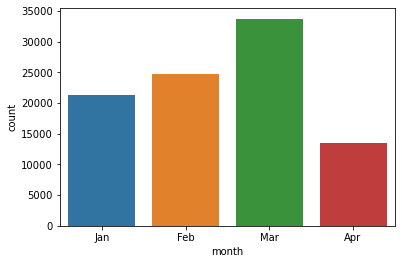

In [11]:
month_count = df2.groupby('month')['count'].sum()
sns.barplot(month_count.index, month_count, order=['Jan', 'Feb', 'Mar', 'Apr'])

- **We can see the login count increasing over the months. The april count consists of till 13th.**


- **The users are increasing.**

### Login count by Day:

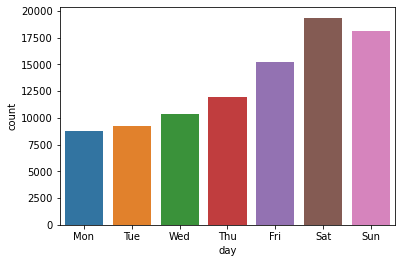

In [12]:
day_count = df2.groupby('day')['count'].sum()
sns.barplot(day_count.index, day_count, order=day)

- **Saturday and Sunday have the highest activity followed by Fiday.**


- **The weekdays have average activity, Monday being the lowest. The activity gradually increases towards the weekend.**


- **Weekend is in high demand than the weekdays.**

### Login count by Hour:

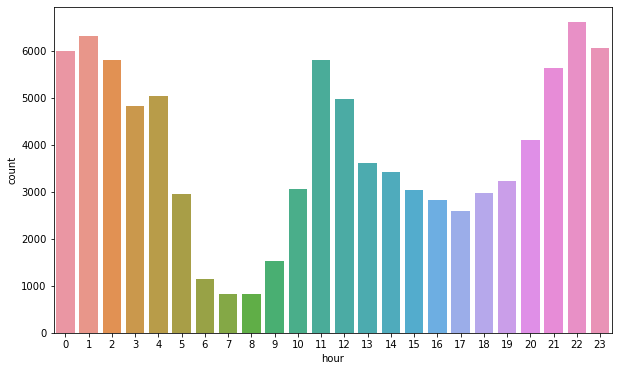

In [13]:
hour_count = df2.groupby('hour')['count'].sum()
plt.figure(figsize=(10,6))
sns.barplot(hour_count.index, hour_count)

- **There is high activity from 9 PM to 4 AM and again around noon time.**


- **Morning time 6 AM to 8 AM have the lowest activity.**


- **Evening time have an average activity.**

# Part 2 ‑ Experiment and metrics design

**The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.**

**However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.**

**1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

Given that Gotham is more active at night and Metropolis is more active at day, it would be beneficial to fill the gap of demand. In other words, drivers based in Gotham should be inclined to take trips during the day in Metropolis and then travel back to Gotham for night trips, and vice versa. 

Assumimg this experiment was sucessful, it would indicate that the drivers, irrespective of which city they belong to, are spending equal amounts of time in Gotham and Metropolis during the weekdays; Metropolis during the day and Gotham during the night.

The key measure of success is to track the ratio of passengers picked up from Gotham and Metropolis on weekdays. The ratio should tend towards 1:1 if the experiment is to be successful.

**2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

- **How you will implement the experiment?**
    
- **What statistical test(s) you will conduct to verify the significance of the observation?**
    
- **How you would interpret the results and provide recommendations to the city operations team along with any caveats?**

Following steps should be implemented as part of the experiment:

1. Track each driver's activity in both the cities. If a driver has more passengers from Gotham, label him as a Gotham driver, else a Metropolis driver.


2. Calculate the proportion of the passengers from the two cities.


3. Perform hypothesis testing using the Two Proportions Z-Test. Calculate the Z-Statisitc and compare it with a significance level, $\alpha$.

    - Null Hypothesis (H0) : The proportions are the same.
   
    - Alternate Hypothesis (H1) : The proportions are not the same.
   
   


4. If the Null Hypothesis holds, the experiment has been a success. If the Alternate hypothesis holds, it has been a failure.

# Part 3 ‑ Predictive modeling

In [14]:
df3 = pd.DataFrame(json.load(open('ultimate_data_challenge.json')))
df3.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Data Overview

In [15]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
df3.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [17]:
#Let's check for nulls
df3.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

## Data Wrangling

**We can see the dtype of the columns ('signup_date' and 'last_trip_date') containing date as object type. Let's convert them.**

In [18]:
df3['signup_date'] = pd.to_datetime(df3['signup_date'])
df3['last_trip_date'] = pd.to_datetime(df3['last_trip_date'])

df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [19]:
#Replacing the null values

df3['avg_rating_of_driver'] = df3['avg_rating_of_driver'].fillna(df3['avg_rating_of_driver'].mean())
df3['avg_rating_by_driver'] = df3['avg_rating_by_driver'].fillna(df3['avg_rating_by_driver'].mean())

In [20]:
df3.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

**Looks like the iPhones are more than Android. So, we will replace the nulls with iPhone.**

In [21]:
df3['phone'] = df3['phone'].fillna('iPhone')

In [22]:
#Let's check for nulls again
df3.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [23]:
df3.last_trip_date.sort_values(ascending=False).head()

45357   2014-07-01
22735   2014-07-01
14473   2014-07-01
38651   2014-07-01
45126   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

**The data was taken on 1st July 2014. So, we consider a user retained if they took a trip in the preceding 30 days, i.e. after 1st June 2014.**

In [24]:
#Let's create the target column called 'retained' based on the 'last_trip_date'.

df3['retained'] = df3['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01') else 0)

df3.retained.value_counts()

0    31196
1    18804
Name: retained, dtype: int64

In [25]:
print('{:.2f}% of users were retained.'.format(len(df3[df3['retained'] == 1])/len(df3['retained'])*100))

37.61% of users were retained.


## Exploratory Data Analysis

### Retain % for Ultimate Black User:

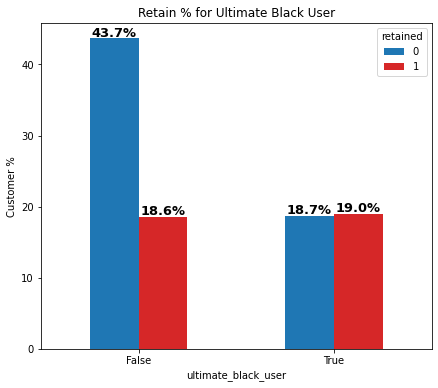

In [26]:
ax = (pd.crosstab(df3.ultimate_black_user, df3.retained)*100/len(df3)).plot(kind='bar', 
                                                                            color=('tab:blue','tab:red'), 
                                                                            figsize=(7,6))
plt.title('Retain % for Ultimate Black User')
plt.ylabel('Customer %')
plt.xticks(rotation='horizontal')
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(str(round(height, 1))+'%', (x + 0.01, y + height + 0.3), fontsize=13, weight='bold')

- **Ultimate Black users consists of only 37.7% users, but 50% of them are likely to be retained.**
- **Ultimate Black can be a huge factor for retaining customers.**

### Retain % by Phone:

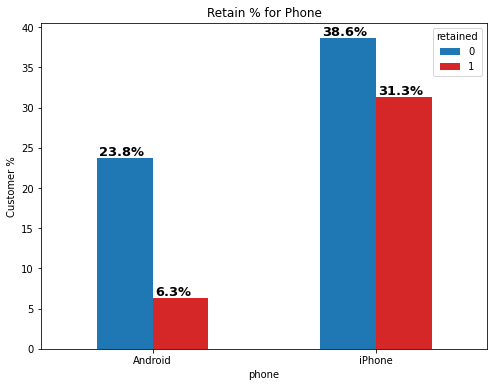

In [27]:
ax = (pd.crosstab(df3.phone, df3.retained)*100/len(df3)).plot(kind='bar', color=('tab:blue','tab:red'), figsize=(8,6))
plt.title('Retain % for Phone')
plt.ylabel('Customer %')
plt.xticks(rotation='horizontal')
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(str(round(height, 1))+'%', (x + 0.01, y + height + 0.3), fontsize=13, weight='bold')

- **Iphones are used by nearly 70% of the users and 44% of them are likely to be retained.**
- **Phone type can be a huge determining factor for retaining customers.**

### Retain % by City:

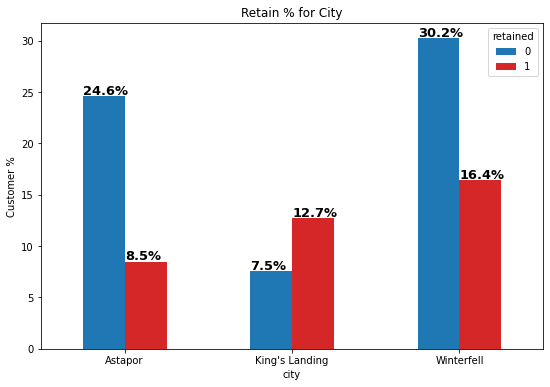

In [28]:
ax = (pd.crosstab(df3.city, df3.retained)*100/len(df3)).plot(kind='bar', color=('tab:blue','tab:red'), figsize=(9,6))
plt.title('Retain % for City')
plt.ylabel('Customer %')
plt.xticks(rotation='horizontal')
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(str(round(height, 1))+'%', (x + 0.001, y + height + 0.2), fontsize=13, weight='bold')

- **King's Landing consists only 20% users, but 63% of them likely to be retained.**
- **Winterfell consists of 46% users and 35% of them are ikely to be retained.**
- **Astapor is the least succesful, retaining ony 25% users from it's 33% user base.**
- **City can be a deciding factor for retaining customers.**

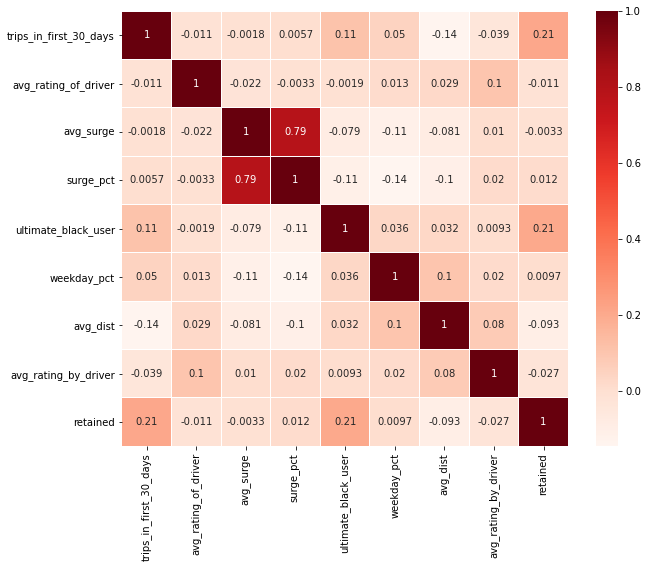

In [29]:
#Correlation matrix

plt.figure(figsize=(10,8))
sns.heatmap(df3.corr(), annot=True, linewidths=0.1, cmap='Reds')

***

**We can see from 'signup_date' all the users signed up on the month of January 2014 and we have already created the target variable 'retained' from the column 'last_trip_date'. So, we don't have much use of these 2 columns now. Let's drop them.**

In [30]:
#Drop the columns
df3 = df3.drop('signup_date', axis=1)
df3 = df3.drop('last_trip_date', axis=1)

In [31]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   50000 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    50000 non-null  float64
 10  retained                50000 non-null  int64  
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 3.9+ MB


## Data Pre-Processing

### Label Encoding and Scaling:

In [32]:
# Label Encoding categorical columns

def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object' or dataframe_series.dtype=='bool':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

df3 = df3.apply(lambda x: object_to_int(x))

# Scaling numercial columns
std = StandardScaler()
scaled = pd.DataFrame(std.fit_transform(df3[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']]), 
                      columns=['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'])

df3 = df3.drop(columns=['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'], axis=1)
df3 = df3.merge(scaled, left_index=True, right_index=True, how="left")
df3.head()

,city,phone,ultimate_black_user,retained,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,1,1,1,1,0.453984,0.174240,0.113506,0.328202,-0.397131,-0.372650,0.497684
1,0,0,0,0,-0.600689,0.705241,-0.336268,-0.443394,-0.294653,0.431583,0.497684
2,0,1,0,0,0.190316,-0.533761,-0.336268,-0.443394,1.053741,-0.880771,0.497684
3,1,1,1,1,1.772325,-0.002760,0.293416,0.558679,0.514383,-0.602181,0.273342
4,2,0,0,0,3.090665,-0.356760,0.518303,0.147829,0.579106,-0.467266,0.273342


## Model Building

In [33]:
X = df3.drop('retained', axis=1)
y = df3['retained']

In [34]:
# Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 40)

In [35]:
classifiers = [['Logistic Regression :', LogisticRegression()],
               ['K Neighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['Decision Tree :',DecisionTreeClassifier()],
               ['Random Forest :',RandomForestClassifier()],
               ['Gradient Boosting :',GradientBoostingClassifier()]]

for name, classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    print(name, accuracy_score(y_test, predictions))

Logistic Regression : 0.6916
K Neighbours : 0.7423
SVM : 0.7659
Decision Tree : 0.706
Random Forest : 0.7486
Gradient Boosting : 0.7852


In [36]:
clf = GradientBoostingClassifier(n_estimators=300)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.7907

- **Our Gradient Boosting Classifier model gives an accuracy of 79%.**

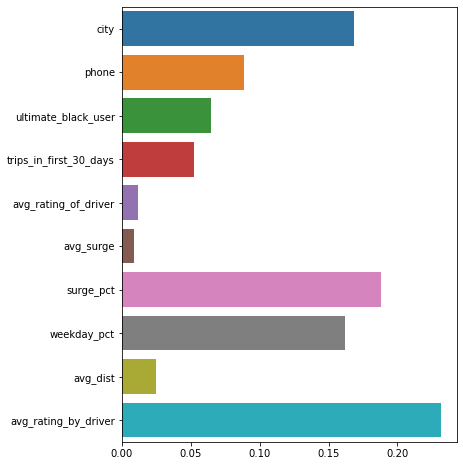

In [37]:
#Feature Importance

plt.figure(figsize=(6,8))
sns.barplot(clf.feature_importances_, X.columns)

### Ultimate may consider the following actions to improve its longterm rider retention:

- **City is one important feature for retaining customers. Customers from King's Landing are retained the most. So, we can implement the methods used in King's Landing in other cities too for retaining customers.**


- **People who use cabs on the weekdays are more likely to be retained. More offers can be provide in the weekdays to encourage people to take cabs to work.**


- **It looks like trips taken with surge multiplier > 1 is an important feature for customer retention. These are likely the customers who tend to use a cab every day to go to work even though there is a surge. So surges too high can be reduced to retain more of the daily cab users.**


- **Average rating by driver is another important feature. Riders with less that or equal to rating 4.9 tend to retain more. 75% of the riders with a rating of 5.0 are not retained. This is probabily because riders with an extremely high rating do not ride very often and, in turn, do not get rated very often.**